# Control points optimization

In [1]:
from shapeOptInductor import gen_meshN, Id
import ngsolve as ngs
from ngsolve.webgui import Draw
import numpy as np
import matplotlib.pyplot as plt

## 1 - Geometry and meshing

We define a geometry with some control points on the airgap profile.

In [2]:
NControlPoints = 6
airgap = 4.11e-3 * np.ones(NControlPoints)

lz = 1e-2  # thickness in the z-direction (m)
s = 4  # symmetry factor

maxh = 4e-3
mesh, p1, p2 = gen_meshN(airgap, maxh)

xPointsAirgap = [p[0] for p in p1 ] + [p[0] for p in p2 ] 

XiAir = mesh.MaterialCF({"air": 1})
XiCore = mesh.MaterialCF({"core": 1})
XiCoil = mesh.MaterialCF({"coil": 1})

materialFunction = 1 * XiAir + 2 * XiCoil + 3 * XiCore
Draw(materialFunction, mesh, radius=0.02)



WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

## 2 - State problem

### a) Parameters definition

In [3]:
f = 5e4  # working frequency (Hz)
omega = 2 * np.pi * f  # rad/s
mu0 = 4e-7 * np.pi  # void permeability (H/m)
mur = 1000  # relative permeability of iron (no unit)
mu_iron = mur * mu0  # permeability of iron (H/m)
delta = 0.1  # loss angle associated with the coil (rad)
mu_coil = np.exp(-1j * delta) * mu0  # complex permeability
nb_turn = 200  # number of turn in the coil (no unit)
Is = 2  # source current intensity (A)
js = nb_turn / 2 * Is / (ngs.Integrate(XiCoil, mesh)) * XiCoil  # source current density (A/m²)


### b) Definition of the magnetic problem

In [4]:
def magWeakFormComplex(a, a_):
    """Return the complex weak form of the magnetic problem, i.e, bilinear
    and linear forms (matrix and right-hand side after discretization, respectively)"""

    # bilinear form (transmission)
    bf = ngs.grad(a_) * 1 / mu_iron * ngs.grad(a) * ngs.dx("core")
    bf += ngs.grad(a_) * 1 / mu_coil * ngs.grad(a) * ngs.dx("coil")
    bf += ngs.grad(a_) * 1 / mu0 * ngs.grad(a) * ngs.dx("air")

    # linear form (source)
    lf = a_ * js * ngs.dx("coil")

    return bf, lf


def solveStateComplex(mesh):
    """Solve the complex magnetic state"""
    # definition of function space
    fes = ngs.H1(mesh, order=1, dirichlet="arc|segment2|domainVert", complex=True)
    a, a_ = fes.TnT()

    # definition of weak form
    bf, f = magWeakFormComplex(a, a_)
    K, F = ngs.BilinearForm(fes), ngs.LinearForm(fes)
    K += bf
    F += f

    # assembly
    K.Assemble()
    F.Assemble()

    # solving
    gf = ngs.GridFunction(fes)
    Kinv = K.mat.Inverse(freedofs=fes.FreeDofs(), inverse="pardiso")
    gf.vec.data = Kinv * F.vec

    return gf, Kinv  # returning Kinv speed up adjoint calculation


### c) Definition of the post-processed quantities

We define the losses and inductance, with the directional derivative of their local quantities.

In [5]:
def Inductance(a, mesh):
    rel = XiAir / mu0 + XiCoil / mu_coil + XiCore / mu_iron
    return s * lz / (Is**2) * ngs.Integrate(rel.real * ngs.Norm(ngs.grad(a)) ** 2, mesh)


def dInductance(a, p_, mesh):
    rel = XiAir / mu0 + XiCoil / mu_coil + XiCore / mu_iron
    return 2 * s * lz / (Is**2) * ngs.InnerProduct(rel.real * ngs.grad(a), ngs.grad(p_)) * ngs.dx()


def Losses(a, mesh):
    rel = XiCoil / mu_coil
    return s * np.pi * f * lz * ngs.Integrate(rel.imag * ngs.Norm(ngs.grad(a)) ** 2, mesh)


def dLosses(a, p_, mesh):
    rel = XiCoil / mu_coil
    return 2 * s * np.pi * f * lz * ngs.InnerProduct(rel.imag * ngs.grad(a), ngs.grad(p_)) * ngs.dx()

## 3 - Adjoint problem

In [6]:
def solveAdjoint(a0, df, Kinv):
    """Solve the adjoint equation for a given df"""
    fes = a0.space
    p, p_ = fes.TnT()
    f = ngs.LinearForm(fes)
    f += -1 * df(a0, p_, fes.mesh)
    f.Assemble()
    gf = ngs.GridFunction(fes)
    gf.vec.data = Kinv.H * f.vec
    return gf

## 4 - Shape derivative

In [7]:
def SDLosses(a0, p0):
    """Shape derivative for the losses inside the coil"""
    mesh = a0.space.mesh
    FESReal = ngs.VectorH1(mesh)
    FEScomplex = ngs.VectorH1(mesh, complex=True)
    X = FEScomplex.TestFunction()

    rel = (1 / mu0) * XiAir + (1 / mu_coil) * XiCoil + (1 / mu_iron) * XiCore
    coeff_losses = s * np.pi * f * lz * (1 / mu_coil).imag
    dA = ngs.div(X) * Id - ngs.grad(X) - ngs.grad(X).trans

    dLOmega = ngs.LinearForm(FEScomplex)
    dLOmega += coeff_losses * ngs.InnerProduct(dA * ngs.grad(a0), ngs.grad(a0)) * ngs.dx("coil")
    dLOmega += -js * XiCoil * ngs.div(X) * p0 * ngs.dx
    dLOmega += ngs.InnerProduct(rel * dA * ngs.grad(a0), ngs.grad(p0)) * ngs.dx
    dLOmega.Assemble()

    dJ = ngs.GridFunction(FESReal)
    dJ.vec.FV().NumPy()[:] = np.real(dLOmega.vec.FV().NumPy()[:])
    return dJ


def SDInductance(a0, p0):
    """Shape derivative for the inductance"""
    mesh = a0.space.mesh
    FESReal = ngs.VectorH1(mesh)
    FEScomplex = ngs.VectorH1(mesh, complex=True)
    X = FEScomplex.TestFunction()

    rel = (1 / mu0) * XiAir + (1 / mu_coil) * XiCoil + (1 / mu_iron) * XiCore
    Id = ngs.CoefficientFunction((1, 0, 0, 1), dims=(2, 2))  # Identity matrix
    coeff_induc = s * lz / (Is**2) * rel.real
    dA = ngs.div(X) * Id - ngs.grad(X) - ngs.grad(X).trans

    dLOmega = ngs.LinearForm(FEScomplex)
    dLOmega += coeff_induc * ngs.InnerProduct(dA * ngs.grad(a0), ngs.grad(a0)) * ngs.dx
    dLOmega += -js * ngs.div(X) * p0 * ngs.dx
    dLOmega += ngs.InnerProduct(rel * dA * ngs.grad(a0), ngs.grad(p0)) * ngs.dx
    dLOmega.Assemble()

    dJ = ngs.GridFunction(FESReal)
    dJ.vec.FV().NumPy()[:] = np.real(dLOmega.vec.FV().NumPy()[:])
    
    return dJ


### Gradient

In [8]:
from shapeOptInductor import referenceVelocity, referenceVelocityN


def shapeGrad(a0, p0, dJ):
    v11, v12, v21, v22 = referenceVelocity(a0.space.mesh)
    dJlf = dJ(a0, p0)
    FES = ngs.VectorH1(a0.space.mesh)
    dJ = ngs.GridFunction(FES)
    dJ.vec.FV().NumPy()[:] = np.real(dJlf.vec.FV().NumPy()[:])
    g11 = ngs.InnerProduct(dJ.vec, v11.vec)
    g12 = ngs.InnerProduct(dJ.vec, v12.vec)
    g21 = ngs.InnerProduct(dJ.vec, v21.vec)
    g22 = ngs.InnerProduct(dJ.vec, v22.vec)
    return g11, g12, g21, g22


def shapeGradN(a0,p0,dJ,xPointsAirgaps):
    velocityFields = referenceVelocityN(a0.space.mesh, xPointsAirgaps)
    dJlf = dJ(a0, p0)
    FES = ngs.VectorH1(a0.space.mesh)
    dJ = ngs.GridFunction(FES)
    dJ.vec.FV().NumPy()[:] = np.real(dJlf.vec.FV().NumPy()[:])
    shapeGradVal = [ ngs.InnerProduct(dJ.vec, refVelocity.vec) for refVelocity in velocityFields]
    return shapeGradVal

## 3 - Optimization

### a) Optimization algorithm
We use an augmented Lagrangian algorithm (saddle point problem) : we maximize with respect to a Lagrange multiplier $l$ a sequence of inner minimization problem with respect to the optimization variables $e$ :

$$ \mathcal L(e,\lambda) = P(e) + \lambda (L(e) - L_0) + \frac{\beta}{2} (L(e) - L_0)^2 $$

In [9]:
# augmented lagrangian
L_target = 1e-3

FEMcounter = [0]

def innerMinimization(airgap, lam, beta, alpha, n_max=50, alpha_min=1e-5, scale=1e4, scene = None):
    n = 0
    airgapMin = 1e-4
    airgapMax = 1.49e-2
    mesh, p1, p2 = gen_meshN(airgap, maxh=maxh)
    xPointsAirgap = [p[0] for p in p1 ] + [p[0] for p in p2 ] 
    a, Kinv = solveStateComplex(mesh)
    loss = Losses(a, mesh)
    ind = Inductance(a, mesh)
    objectiveHistory = [loss + lam * (scale * (ind - L_target)) + beta / 2 * (scale * (ind - L_target)) ** 2]
    constraintHistory = [ind - L_target]
    airgapHistory = [airgap.copy()]
    inductanceHistory = [ind]
    lossesHistory = [loss]
    while n < n_max and alpha > alpha_min:
        mesh, _, _ = gen_meshN(airgap, maxh=maxh)
        if scene is not None :
            scene.Redraw(materialFunction, mesh)
        # 1) state computation :
        a, Kinv = solveStateComplex(mesh)
        FEMcounter[0] +=1

        # 2) adjoint computation :
        pInd = solveAdjoint(a, dInductance, Kinv)
        # Not counted since we have Kinv already

        pLos = solveAdjoint(a, dLosses, Kinv)

        # 3) gradient evaluation :
        gradient = np.array(shapeGradN(a, pLos, SDLosses, xPointsAirgap))
        gradient += lam * scale * np.array(shapeGradN(a, pInd, SDInductance, xPointsAirgap))
        gradient += beta * scale**2 * (Inductance(a, mesh) - L_target) * np.array(shapeGradN(a, pInd, SDInductance, xPointsAirgap))

        # 4) update :
        airgapTest = airgap - alpha * gradient / np.linalg.norm(gradient)
        n += 1

        # 5) projection :
        airgapTest[airgapTest < airgapMin] = airgapMin
        airgapTest[airgapTest > airgapMax] = airgapMax

        # 6) basic step control :
        meshTest, _, _  = gen_meshN(airgapTest, maxh=maxh)
        a_test, _ = solveStateComplex(meshTest)
        FEMcounter[0] +=1
        
        loss = Losses(a_test, meshTest)
        ind = Inductance(a_test, meshTest)
        objectiveHistory.append(loss + lam * scale * (ind - L_target) + beta / 2 * (scale * (ind - L_target)) ** 2)
        constraintHistory.append(ind - L_target)
        inductanceHistory.append(ind)
        lossesHistory.append(loss)

        print(
            f"it n°{n} | f = {objectiveHistory[-1] :.5e} | L = {inductanceHistory[-1]:.5e} | P = {lossesHistory[-1]:.5e} | step = {alpha : .2e}"
        )

        if objectiveHistory[-1] >= objectiveHistory[-2]:
            alpha = alpha / 2
            objectiveHistory.pop()
            constraintHistory.pop()
            inductanceHistory.pop()
            lossesHistory.pop()
        elif objectiveHistory[-1] < objectiveHistory[-2]:
            alpha = alpha * 1.2
            airgap = airgapTest
            airgapHistory.append(airgap)
    return airgap, alpha, objectiveHistory, constraintHistory, lossesHistory, inductanceHistory, airgapHistory


### b) Optimization Loop

In [10]:
import pickle

NControlPoints = np.arange(4,31,2)

ConstListAll = []
LagrListAll = []
lamListAll = []
LossListAll = []
InductanceListAll = []
AirgapListAll = []
MeshListAll = []


for iN in range(len(NControlPoints)):
    print("-----------------------------------")
    print("N = ", NControlPoints[iN])

    ## Initialisation
    airgap = 4.11e-3 * np.ones(NControlPoints[iN])
    lam = 0
    scale = 1e3
    beta = 500  # Penalization coefficient
    alpha = 1e-3 / 2  # Initial step
    FEMcounter[0] =0
    alpha_min = 1e-8  # Minimal step
    N_max = 20  # Nombre d'itérations de l'algorithme d'optimisation
    n_max = 20

    ConstList = []
    LagrList = []
    lamList = [lam]
    LossList = []
    InductanceList = []
    AirgapList = []
    N = 0

    mesh ,_ ,_ = gen_meshN(airgap, maxh=maxh)
    scene = Draw(materialFunction, mesh)
    while N < N_max:
        airgap, alpha, lagrList, constList, lossList, inductanceList, airgapList = innerMinimization(
            airgap, lam, beta, alpha=2 * alpha, n_max=n_max, alpha_min=alpha_min, scale=scale, scene= scene
        )
        lam += beta * constList[-1]
        print(f"{lam = }")
        lamList.append(lam)
        LagrList += lagrList
        ConstList += constList
        LossList += lossList
        InductanceList += inductanceList
        AirgapList += airgapList
        N += 1

    TotalCount = FEMcounter[0]
    mesh, p1, p2 = gen_meshN(AirgapList[-1])
    resultsToSave = {"LossList": LossList, 
                     "InductanceList": InductanceList, 
                     "AirgapList": AirgapList, 
                     "Mesh": mesh, 
                     "xAirgap": [p[0] for p in p1] + [p[0] for p in p2], 
                     "NLAgr" : N,
                     "NFEM" : TotalCount,
                     }
    
    filename = "results/gradient_based_N"+ str(NControlPoints[iN]) +".pkl"
    with open(filename, 'wb') as fileToSave:
        pickle.dump(resultsToSave, fileToSave)

    ConstListAll.append(ConstList)
    LagrListAll.append(LagrList)
    lamListAll.append(lamList)
    LossListAll.append(LossList)
    InductanceListAll.append(InductanceList)
    AirgapListAll.append(AirgapList)
    MeshListAll.append(gen_meshN(AirgapList[-1])[0])


-----------------------------------
N =  4


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

it n°1 | f = 1.26357e+01 | L = 9.36926e-04 | P = 1.16411e+01 | step =  1.00e-03
it n°2 | f = 1.27583e+01 | L = 1.05544e-03 | P = 1.19899e+01 | step =  1.20e-03
it n°3 | f = 1.18358e+01 | L = 9.91959e-04 | P = 1.18196e+01 | step =  6.00e-04
it n°4 | f = 1.11492e+01 | L = 9.73034e-04 | P = 1.09675e+01 | step =  7.20e-04
it n°5 | f = 1.09804e+01 | L = 1.03970e-03 | P = 1.05864e+01 | step =  8.64e-04
it n°6 | f = 1.10754e+01 | L = 9.30140e-04 | P = 9.85527e+00 | step =  1.04e-03
it n°7 | f = 1.02971e+01 | L = 9.81472e-04 | P = 1.02112e+01 | step =  5.18e-04
it n°8 | f = 9.96203e+00 | L = 1.02477e-03 | P = 9.80867e+00 | step =  6.22e-04
it n°9 | f = 1.00358e+01 | L = 9.46122e-04 | P = 9.31005e+00 | step =  7.46e-04
it n°10 | f = 9.63667e+00 | L = 9.84183e-04 | P = 9.57413e+00 | step =  3.73e-04
it n°11 | f = 9.36643e+00 | L = 1.01820e-03 | P = 9.28365e+00 | step =  4.48e-04
it n°12 | f = 9.32498e+00 | L = 9.61483e-04 | P = 8.95409e+00 | step =  5.37e-04
it n°13 | f = 9.31415e+00 | L = 1.043

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

it n°1 | f = 1.19748e+01 | L = 9.63248e-04 | P = 1.16371e+01 | step =  1.00e-03
it n°2 | f = 1.16616e+01 | L = 1.04929e-03 | P = 1.10542e+01 | step =  1.20e-03
it n°3 | f = 1.17579e+01 | L = 9.21257e-04 | P = 1.02078e+01 | step =  1.44e-03
it n°4 | f = 1.06850e+01 | L = 9.80386e-04 | P = 1.05888e+01 | step =  7.20e-04
it n°5 | f = 1.03008e+01 | L = 1.03255e-03 | P = 1.00360e+01 | step =  8.64e-04
it n°6 | f = 1.04400e+01 | L = 9.39035e-04 | P = 9.51085e+00 | step =  1.04e-03
it n°7 | f = 9.83801e+00 | L = 9.83195e-04 | P = 9.76741e+00 | step =  5.18e-04
it n°8 | f = 9.56176e+00 | L = 1.02523e-03 | P = 9.40258e+00 | step =  6.22e-04
it n°9 | f = 9.52680e+00 | L = 9.55912e-04 | P = 9.04086e+00 | step =  7.46e-04
it n°10 | f = 9.46632e+00 | L = 1.04804e-03 | P = 8.88928e+00 | step =  8.96e-04
it n°11 | f = 9.67597e+00 | L = 9.35565e-04 | P = 8.63800e+00 | step =  1.07e-03
it n°12 | f = 8.80236e+00 | L = 9.86918e-04 | P = 8.75958e+00 | step =  5.37e-04
it n°13 | f = 8.77873e+00 | L = 1.036

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

it n°1 | f = 1.19219e+01 | L = 9.70507e-04 | P = 1.17044e+01 | step =  1.00e-03
it n°2 | f = 1.11006e+01 | L = 1.02850e-03 | P = 1.08976e+01 | step =  1.20e-03
it n°3 | f = 1.10900e+01 | L = 9.32044e-04 | P = 9.93553e+00 | step =  1.44e-03
it n°4 | f = 1.13247e+01 | L = 1.08002e-03 | P = 9.72397e+00 | step =  1.73e-03
it n°5 | f = 9.84619e+00 | L = 9.98451e-04 | P = 9.84559e+00 | step =  8.64e-04
it n°6 | f = 9.04203e+00 | L = 9.98080e-04 | P = 9.04110e+00 | step =  1.04e-03
it n°7 | f = 8.28534e+00 | L = 1.01411e-03 | P = 8.23555e+00 | step =  1.24e-03
it n°8 | f = 1.00403e+01 | L = 9.04103e-04 | P = 7.74121e+00 | step =  1.49e-03
it n°9 | f = 8.48720e+00 | L = 9.55208e-04 | P = 7.98563e+00 | step =  7.46e-04
it n°10 | f = 8.18067e+00 | L = 9.83556e-04 | P = 8.11307e+00 | step =  3.73e-04
it n°11 | f = 8.09190e+00 | L = 1.02429e-03 | P = 7.94442e+00 | step =  4.48e-04
it n°12 | f = 8.08807e+00 | L = 9.69966e-04 | P = 7.86255e+00 | step =  5.37e-04
it n°13 | f = 8.10262e+00 | L = 1.038

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

it n°1 | f = 1.19270e+01 | L = 9.73860e-04 | P = 1.17562e+01 | step =  1.00e-03
it n°2 | f = 1.09578e+01 | L = 1.01536e-03 | P = 1.08988e+01 | step =  1.20e-03
it n°3 | f = 1.04684e+01 | L = 9.49601e-04 | P = 9.83343e+00 | step =  1.44e-03
it n°4 | f = 1.11664e+01 | L = 1.08217e-03 | P = 9.47850e+00 | step =  1.73e-03
it n°5 | f = 9.66903e+00 | L = 1.00856e-03 | P = 9.65069e+00 | step =  8.64e-04
it n°6 | f = 9.23492e+00 | L = 9.69308e-04 | P = 8.99943e+00 | step =  1.04e-03
it n°7 | f = 9.90519e+00 | L = 1.07098e-03 | P = 8.64552e+00 | step =  1.24e-03
it n°8 | f = 8.86876e+00 | L = 1.01527e-03 | P = 8.81044e+00 | step =  6.22e-04
it n°9 | f = 8.76396e+00 | L = 9.68422e-04 | P = 8.51467e+00 | step =  7.46e-04
it n°10 | f = 8.75961e+00 | L = 1.04339e-03 | P = 8.28903e+00 | step =  8.96e-04
it n°11 | f = 8.82602e+00 | L = 9.49145e-04 | P = 8.17945e+00 | step =  1.07e-03
it n°12 | f = 8.25673e+00 | L = 9.93133e-04 | P = 8.24494e+00 | step =  5.37e-04
it n°13 | f = 8.09702e+00 | L = 1.025

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

it n°1 | f = 1.19421e+01 | L = 9.75758e-04 | P = 1.17952e+01 | step =  1.00e-03
it n°2 | f = 1.09561e+01 | L = 1.00741e-03 | P = 1.09423e+01 | step =  1.20e-03
it n°3 | f = 1.01089e+01 | L = 9.65898e-04 | P = 9.81815e+00 | step =  1.44e-03
it n°4 | f = 1.08973e+01 | L = 1.07948e-03 | P = 9.31824e+00 | step =  1.73e-03
it n°5 | f = 9.62855e+00 | L = 1.01675e-03 | P = 9.55843e+00 | step =  8.64e-04
it n°6 | f = 9.38933e+00 | L = 9.64057e-04 | P = 9.06636e+00 | step =  1.04e-03
it n°7 | f = 9.43536e+00 | L = 1.05162e-03 | P = 8.76911e+00 | step =  1.24e-03
it n°8 | f = 8.92642e+00 | L = 1.00457e-03 | P = 8.92119e+00 | step =  6.22e-04
it n°9 | f = 8.54819e+00 | L = 9.88052e-04 | P = 8.51250e+00 | step =  7.46e-04
it n°10 | f = 8.51865e+00 | L = 1.03836e-03 | P = 8.15077e+00 | step =  8.96e-04
it n°11 | f = 8.56994e+00 | L = 9.53911e-04 | P = 8.03889e+00 | step =  1.07e-03
it n°12 | f = 8.10132e+00 | L = 9.93565e-04 | P = 8.09097e+00 | step =  5.37e-04
it n°13 | f = 7.94892e+00 | L = 1.022

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

it n°1 | f = 1.19701e+01 | L = 9.77023e-04 | P = 1.18381e+01 | step =  1.00e-03
it n°2 | f = 1.09554e+01 | L = 1.00059e-03 | P = 1.09554e+01 | step =  1.20e-03
it n°3 | f = 9.97633e+00 | L = 9.82106e-04 | P = 9.89628e+00 | step =  1.44e-03
it n°4 | f = 9.91284e+00 | L = 1.05660e-03 | P = 9.11205e+00 | step =  1.73e-03
it n°5 | f = 1.03171e+01 | L = 9.22171e-04 | P = 8.80274e+00 | step =  2.07e-03
it n°6 | f = 9.02403e+00 | L = 9.83430e-04 | P = 8.95539e+00 | step =  1.04e-03
it n°7 | f = 9.08910e+00 | L = 1.04798e-03 | P = 8.51354e+00 | step =  1.24e-03
it n°8 | f = 8.77722e+00 | L = 1.01387e-03 | P = 8.72914e+00 | step =  6.22e-04
it n°9 | f = 8.58386e+00 | L = 9.76471e-04 | P = 8.44546e+00 | step =  7.46e-04
it n°10 | f = 8.52087e+00 | L = 1.03421e-03 | P = 8.22824e+00 | step =  8.96e-04
it n°11 | f = 8.50524e+00 | L = 9.59355e-04 | P = 8.09224e+00 | step =  1.07e-03
it n°12 | f = 8.60626e+00 | L = 1.05329e-03 | P = 7.89621e+00 | step =  1.29e-03
it n°13 | f = 7.98659e+00 | L = 1.002

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

it n°1 | f = 1.19925e+01 | L = 9.78119e-04 | P = 1.18728e+01 | step =  1.00e-03
it n°2 | f = 1.10150e+01 | L = 9.97073e-04 | P = 1.10129e+01 | step =  1.20e-03
it n°3 | f = 1.00075e+01 | L = 9.88709e-04 | P = 9.97563e+00 | step =  1.44e-03
it n°4 | f = 9.35814e+00 | L = 1.03172e-03 | P = 9.10667e+00 | step =  1.73e-03
it n°5 | f = 1.02352e+01 | L = 9.18950e-04 | P = 8.59291e+00 | step =  2.07e-03
it n°6 | f = 9.04488e+00 | L = 9.71400e-04 | P = 8.84039e+00 | step =  1.04e-03
it n°7 | f = 9.04765e+00 | L = 1.04367e-03 | P = 8.57086e+00 | step =  1.24e-03
it n°8 | f = 8.70145e+00 | L = 1.00501e-03 | P = 8.69518e+00 | step =  6.22e-04
it n°9 | f = 8.38804e+00 | L = 9.88991e-04 | P = 8.35774e+00 | step =  7.46e-04
it n°10 | f = 8.26605e+00 | L = 1.02932e-03 | P = 8.05117e+00 | step =  8.96e-04
it n°11 | f = 8.32154e+00 | L = 9.59969e-04 | P = 7.92093e+00 | step =  1.07e-03
it n°12 | f = 8.00025e+00 | L = 9.93306e-04 | P = 7.98905e+00 | step =  5.37e-04
it n°13 | f = 7.83365e+00 | L = 1.017

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

it n°1 | f = 1.20141e+01 | L = 9.79119e-04 | P = 1.19051e+01 | step =  1.00e-03
it n°2 | f = 1.10736e+01 | L = 9.94408e-04 | P = 1.10658e+01 | step =  1.20e-03
it n°3 | f = 1.00953e+01 | L = 9.92683e-04 | P = 1.00819e+01 | step =  1.44e-03
it n°4 | f = 9.21988e+00 | L = 1.01370e-03 | P = 9.17298e+00 | step =  1.73e-03
it n°5 | f = 9.36184e+00 | L = 9.37174e-04 | P = 8.37505e+00 | step =  2.07e-03
it n°6 | f = 8.93901e+00 | L = 9.73258e-04 | P = 8.76023e+00 | step =  1.04e-03
it n°7 | f = 8.88080e+00 | L = 1.04036e-03 | P = 8.47348e+00 | step =  1.24e-03
it n°8 | f = 8.87974e+00 | L = 9.51609e-04 | P = 8.29431e+00 | step =  1.49e-03
it n°9 | f = 9.07863e+00 | L = 1.06321e-03 | P = 8.07961e+00 | step =  1.79e-03
it n°10 | f = 8.18830e+00 | L = 1.00262e-03 | P = 8.18659e+00 | step =  8.96e-04
it n°11 | f = 7.78948e+00 | L = 9.91833e-04 | P = 7.77280e+00 | step =  1.07e-03
it n°12 | f = 8.06486e+00 | L = 1.05136e-03 | P = 7.40529e+00 | step =  1.29e-03
it n°13 | f = 7.67370e+00 | L = 1.019

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

it n°1 | f = 1.20394e+01 | L = 9.79897e-04 | P = 1.19383e+01 | step =  1.00e-03
it n°2 | f = 1.11151e+01 | L = 9.92054e-04 | P = 1.10993e+01 | step =  1.20e-03
it n°3 | f = 1.01585e+01 | L = 9.94837e-04 | P = 1.01518e+01 | step =  1.44e-03
it n°4 | f = 9.25682e+00 | L = 1.00396e-03 | P = 9.25290e+00 | step =  1.73e-03
it n°5 | f = 8.49607e+00 | L = 9.73733e-04 | P = 8.32358e+00 | step =  2.07e-03
it n°6 | f = 1.20561e+01 | L = 1.12867e-03 | P = 7.91719e+00 | step =  2.49e-03
it n°7 | f = 8.52226e+00 | L = 1.04145e-03 | P = 8.09282e+00 | step =  1.24e-03
it n°8 | f = 8.21975e+00 | L = 1.00553e-03 | P = 8.21210e+00 | step =  6.22e-04
it n°9 | f = 7.97036e+00 | L = 9.88589e-04 | P = 7.93780e+00 | step =  7.46e-04
it n°10 | f = 7.93902e+00 | L = 1.02993e-03 | P = 7.71510e+00 | step =  8.96e-04
it n°11 | f = 7.92018e+00 | L = 9.65167e-04 | P = 7.61685e+00 | step =  1.07e-03
it n°12 | f = 7.99117e+00 | L = 1.04574e-03 | P = 7.46813e+00 | step =  1.29e-03
it n°13 | f = 7.53880e+00 | L = 1.002

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

it n°1 | f = 1.20560e+01 | L = 9.79928e-04 | P = 1.19552e+01 | step =  1.00e-03
it n°2 | f = 1.11622e+01 | L = 9.90859e-04 | P = 1.11414e+01 | step =  1.20e-03
it n°3 | f = 1.02378e+01 | L = 9.94697e-04 | P = 1.02307e+01 | step =  1.44e-03
it n°4 | f = 9.34137e+00 | L = 1.00199e-03 | P = 9.34038e+00 | step =  1.73e-03
it n°5 | f = 8.50839e+00 | L = 9.83811e-04 | P = 8.44287e+00 | step =  2.07e-03
it n°6 | f = 1.07861e+01 | L = 1.10808e-03 | P = 7.86595e+00 | step =  2.49e-03
it n°7 | f = 8.49327e+00 | L = 1.03846e-03 | P = 8.12354e+00 | step =  1.24e-03
it n°8 | f = 8.45958e+00 | L = 9.56515e-04 | P = 7.98685e+00 | step =  1.49e-03
it n°9 | f = 8.69076e+00 | L = 1.05955e-03 | P = 7.80411e+00 | step =  1.79e-03
it n°10 | f = 7.88898e+00 | L = 1.00391e-03 | P = 7.88515e+00 | step =  8.96e-04
it n°11 | f = 7.58609e+00 | L = 9.86581e-04 | P = 7.54107e+00 | step =  1.07e-03
it n°12 | f = 8.06424e+00 | L = 1.05558e-03 | P = 7.29189e+00 | step =  1.29e-03
it n°13 | f = 7.50434e+00 | L = 1.018

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

it n°1 | f = 1.20846e+01 | L = 9.80900e-04 | P = 1.19934e+01 | step =  1.00e-03
it n°2 | f = 1.12162e+01 | L = 9.89172e-04 | P = 1.11869e+01 | step =  1.20e-03
it n°3 | f = 1.03213e+01 | L = 9.95897e-04 | P = 1.03171e+01 | step =  1.44e-03
it n°4 | f = 9.43542e+00 | L = 9.96970e-04 | P = 9.43313e+00 | step =  1.73e-03
it n°5 | f = 8.55514e+00 | L = 1.00617e-03 | P = 8.54562e+00 | step =  2.07e-03
it n°6 | f = 8.18660e+00 | L = 9.56976e-04 | P = 7.72384e+00 | step =  2.49e-03
it n°7 | f = 1.31131e+01 | L = 1.14954e-03 | P = 7.52267e+00 | step =  2.99e-03
it n°8 | f = 7.97457e+00 | L = 1.03950e-03 | P = 7.58445e+00 | step =  1.49e-03
it n°9 | f = 8.36478e+00 | L = 9.41013e-04 | P = 7.49491e+00 | step =  1.79e-03
it n°10 | f = 7.58194e+00 | L = 9.86807e-04 | P = 7.53843e+00 | step =  8.96e-04
it n°11 | f = 7.73174e+00 | L = 1.03970e-03 | P = 7.33779e+00 | step =  1.07e-03
it n°12 | f = 7.46835e+00 | L = 1.01158e-03 | P = 7.43481e+00 | step =  5.37e-04
it n°13 | f = 7.38989e+00 | L = 9.832

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

it n°1 | f = 1.21051e+01 | L = 9.81618e-04 | P = 1.20206e+01 | step =  1.00e-03
it n°2 | f = 1.12391e+01 | L = 9.87666e-04 | P = 1.12011e+01 | step =  1.20e-03
it n°3 | f = 1.03679e+01 | L = 9.96236e-04 | P = 1.03644e+01 | step =  1.44e-03
it n°4 | f = 9.51812e+00 | L = 9.94834e-04 | P = 9.51145e+00 | step =  1.73e-03
it n°5 | f = 8.69756e+00 | L = 1.01288e-03 | P = 8.65608e+00 | step =  2.07e-03
it n°6 | f = 9.03356e+00 | L = 9.34972e-04 | P = 7.97640e+00 | step =  2.49e-03
it n°7 | f = 8.50808e+00 | L = 9.71776e-04 | P = 8.30893e+00 | step =  1.24e-03
it n°8 | f = 8.53817e+00 | L = 1.04298e-03 | P = 8.07628e+00 | step =  1.49e-03
it n°9 | f = 8.19501e+00 | L = 1.00514e-03 | P = 8.18841e+00 | step =  7.46e-04
it n°10 | f = 7.93848e+00 | L = 9.88839e-04 | P = 7.90733e+00 | step =  8.96e-04
it n°11 | f = 7.89494e+00 | L = 1.03078e-03 | P = 7.65812e+00 | step =  1.07e-03
it n°12 | f = 7.89766e+00 | L = 9.63554e-04 | P = 7.56558e+00 | step =  1.29e-03
it n°13 | f = 7.60338e+00 | L = 9.954

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

it n°1 | f = 1.21183e+01 | L = 9.82036e-04 | P = 1.20376e+01 | step =  1.00e-03
it n°2 | f = 1.12798e+01 | L = 9.86910e-04 | P = 1.12369e+01 | step =  1.20e-03
it n°3 | f = 1.04291e+01 | L = 9.95615e-04 | P = 1.04243e+01 | step =  1.44e-03
it n°4 | f = 9.58786e+00 | L = 9.95636e-04 | P = 9.58310e+00 | step =  1.73e-03
it n°5 | f = 8.74647e+00 | L = 1.00684e-03 | P = 8.73478e+00 | step =  2.07e-03
it n°6 | f = 8.37521e+00 | L = 9.58663e-04 | P = 7.94802e+00 | step =  2.49e-03
it n°7 | f = 1.16154e+01 | L = 1.12528e-03 | P = 7.69153e+00 | step =  2.99e-03
it n°8 | f = 8.05194e+00 | L = 1.03211e-03 | P = 7.79418e+00 | step =  1.49e-03
it n°9 | f = 8.39595e+00 | L = 9.45231e-04 | P = 7.64604e+00 | step =  1.79e-03
it n°10 | f = 7.77591e+00 | L = 9.85620e-04 | P = 7.72422e+00 | step =  8.96e-04
it n°11 | f = 7.78956e+00 | L = 1.03251e-03 | P = 7.52530e+00 | step =  1.07e-03
it n°12 | f = 7.63474e+00 | L = 1.00795e-03 | P = 7.61895e+00 | step =  5.37e-04
it n°13 | f = 7.51354e+00 | L = 9.887

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

it n°1 | f = 1.21372e+01 | L = 9.82500e-04 | P = 1.20606e+01 | step =  1.00e-03
it n°2 | f = 1.13016e+01 | L = 9.85941e-04 | P = 1.12522e+01 | step =  1.20e-03
it n°3 | f = 1.04881e+01 | L = 9.95951e-04 | P = 1.04840e+01 | step =  1.44e-03
it n°4 | f = 9.64812e+00 | L = 9.93096e-04 | P = 9.63620e+00 | step =  1.73e-03
it n°5 | f = 8.88954e+00 | L = 1.01458e-03 | P = 8.83638e+00 | step =  2.07e-03
it n°6 | f = 9.11031e+00 | L = 9.38656e-04 | P = 8.16954e+00 | step =  2.49e-03
it n°7 | f = 8.65522e+00 | L = 9.74590e-04 | P = 8.49380e+00 | step =  1.24e-03
it n°8 | f = 8.59020e+00 | L = 1.03643e-03 | P = 8.25844e+00 | step =  1.49e-03
it n°9 | f = 8.57316e+00 | L = 9.55381e-04 | P = 8.07545e+00 | step =  1.79e-03
it n°10 | f = 8.71134e+00 | L = 1.05792e-03 | P = 7.87281e+00 | step =  2.15e-03
it n°11 | f = 7.97584e+00 | L = 1.00293e-03 | P = 7.97370e+00 | step =  1.07e-03
it n°12 | f = 7.62261e+00 | L = 9.90938e-04 | P = 7.60209e+00 | step =  1.29e-03
it n°13 | f = 7.88706e+00 | L = 1.049

AttributeError: 'str' object has no attribute 'items'

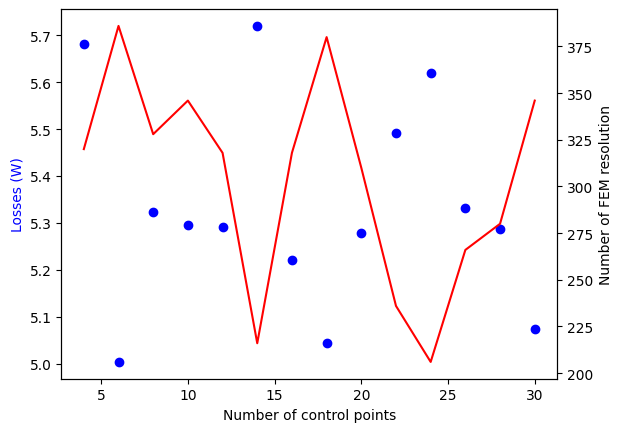

In [ ]:
LossFinal = []
InductanceFinal = []
NFEMFinal = []
for iN in range(len(NControlPoints)):
    filename = "results/gradient_based_N"+ str(NControlPoints[iN]) +".pkl"
    with open(filename, "rb") as input_file:
        res = pickle.load(input_file)
    LossFinal.append(res["LossList"][-1])
    InductanceFinal.append(res["InductanceList"][-1])
    NFEMFinal.append(res["NFEM"])

ax1 = plt.plot(NControlPoints,LossFinal, 'o', color="b")
plt.ylabel("Losses (W)", color="b")
plt.xlabel("Number of control points")
ax2 = plt.gca().twinx()
ax2.plot(NControlPoints,NFEMFinal, '*', color="r")
plt.ylabel("Number of FEM resolution", color="r")
plt.show()

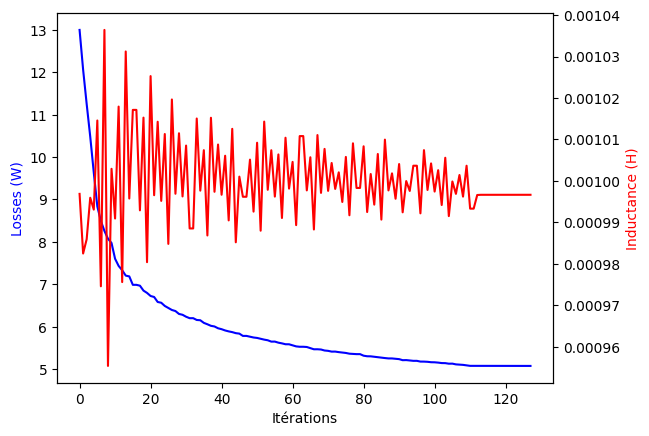

In [ ]:
# Display convergence



ax1 = plt.plot(LossList, color="b")
plt.ylabel("Losses (W)", color="b")
plt.xlabel("Itérations")
ax2 = plt.gca().twinx()
ax2.plot(InductanceList, color="r")
plt.ylabel("Inductance (H)", color="r")
plt.show()


In [12]:
print(f"It : {len(InductanceList)} | P = {LossList[-1]:.2f} W | L = {InductanceList[-1]*1e3 :.2f} mH ")


It : 128 | P = 5.07 W | L = 1.00 mH 
